In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
df = pd.read_csv(r'C:\Users\IALAB\Downloads\WESAD-master\data_sync_30_075\may14_feats4.csv', index_col=0)
random = 13577

In [ ]:
SIGNAL_CATEGORIES = {
    'ECG_BVP': ['HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF', 'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm'],
    'EDA': ['EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_range', 'EDA_slope', 'scl_mean', 'scl_std', 'scr_mean', 'scr_std', 'corr_scl_t', 'scr_count', 'scr_amp', 'scr_sum', 'scr_area'],
    'EMG': ['EMG_mean', 'EMG_std', 'EMG_median', 'EMG_p10', 'EMG_p90', 'EMG_range', 'EMG_sum', 'EMG_f_peak', 'EMG_PSD_bands', 'EMG_peak_count', 'EMG_peak_amp_mean', 'EMG_peak_amp_std', 'EMG_peak_amp_sum', 'EMG_peak_amp_norm'],
    'RESP': ['Resp_mean', 'Resp_std', 'Resp_I_mean', 'Resp_I_std', 'Resp_E_mean', 'Resp_E_std', 'Resp_IE_ratio', 'Resp_range', 'Resp_insp_vol', 'Resp_rate', 'Resp_duration'],
    'TEMP': ['Temp_mean', 'Temp_std', 'Temp_min', 'Temp_max', 'Temp_range', 'Temp_slope']
}
random = 13577

In [ ]:
X = df.drop(columns=["subject", "label"])  # Eliminamos las columnas no relevantes
y = df["label"]  # Variable objetivo

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
X_train.shape, X_test.shape

((33947, 44), (8487, 44))

In [6]:
def calculate_metrics(y_true, y_pred, stage):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1, average='weighted')
    recall = recall_score(y_true, y_pred, pos_label=1, average='weighted')
    f1 = f1_score(y_true, y_pred, pos_label=1, average='weighted')

    metrics_table = pd.DataFrame({
        "Métrica": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Valor": [accuracy, precision, recall, f1]
    })
    
    print(f"{stage} Metrics")
    print(metrics_table)
    return metrics_table

In [7]:
def plot_confusion_matrix(y_true, y_pred, stage):
    conf_mat = confusion_matrix(y_true, y_pred)
    print(f"{stage} Confusion Matrix")
    print(conf_mat)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, cmap="BuPu", fmt="d")
    plt.xlabel("Etiquetas predichas")
    plt.ylabel("Etiquetas verdaderas")
    if stage == 'Validation':
        plt.title("Matriz de confusión para el conjunto de validación")
    else:
        plt.title("Matriz de confusión para el conjunto de prueba")
    plt.show()

In [8]:
def train_and_evaluate(model, param_grid, X_train, Y_train, X_test, Y_test):

    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=random)

    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=10)
    grid_search.fit(X_train, Y_train)
    best_model = grid_search.best_estimator_


    
    print("Mejor modelo:", grid_search.best_params_)
    
    # Evaluación en el conjunto de prueba
    y_test_pred = best_model.predict(X_test)
    calculate_metrics(Y_test, y_test_pred, stage="Test")
    plot_confusion_matrix(Y_test, y_test_pred, stage="Test")


*RANDOM FOREST*

In [18]:
param_gridrRD = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

randomfor_model = RandomForestClassifier(random_state=random)

print("Sin balanceo")
train_and_evaluate(randomfor_model, param_gridrRD, X_train, y_train, X_test, y_test)

Sin balanceo


KeyboardInterrupt: 

*ADA BOOST*

Mejor modelo: {'estimator__max_depth': 10, 'n_estimators': 58}
Test Metrics
     Métrica     Valor
0   Accuracy  0.999921
1  Precision  0.999921
2     Recall  0.999921
3   F1 Score  0.999921
Test Confusion Matrix
[[6868    0    0]
 [   0 3809    0]
 [   1    0 2052]]


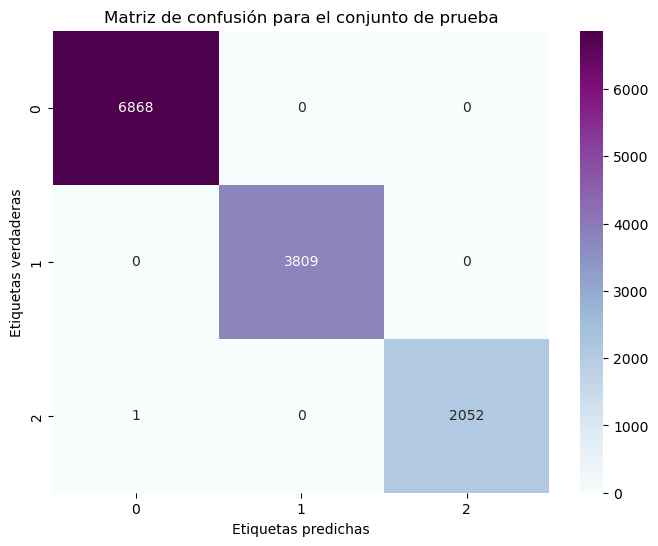

In [ ]:
param_gridADA = {
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 58],
    'estimator__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
}

base_estimator = DecisionTreeClassifier(random_state=random)
adaboost_model = AdaBoostClassifier(estimator=base_estimator, random_state=random)

train_and_evaluate(adaboost_model, param_gridADA, X_train, y_train, X_test, y_test)

*KNN*

Mejor modelo: {'algorithm': 'ball_tree', 'n_neighbors': 2, 'weights': 'distance'}
Test Metrics
     Métrica     Valor
0   Accuracy  0.994580
1  Precision  0.994579
2     Recall  0.994580
3   F1 Score  0.994577
Test Confusion Matrix
[[6849   10    9]
 [  21 3784    4]
 [  15   10 2028]]


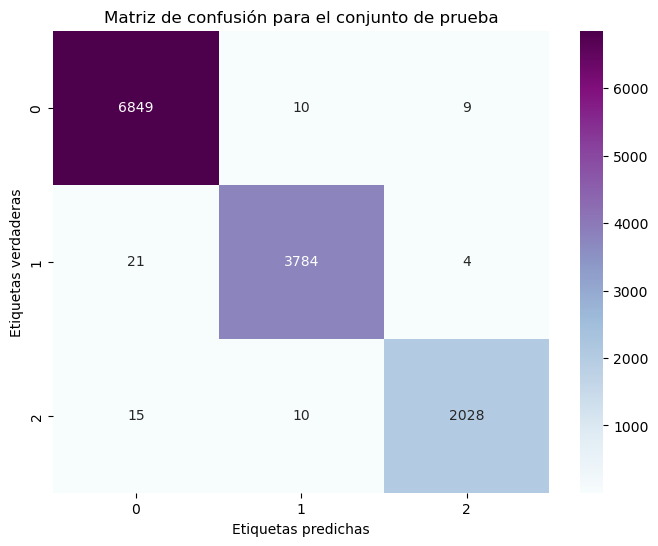

In [ ]:
param_gridKNN = {
    'n_neighbors': [2, 3, 4, 5, 8, 10, 12, 15, 18, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree']
}

knn_model = KNeighborsClassifier()

train_and_evaluate(knn_model, param_gridKNN, X_train, y_train, X_test, y_test)

*DECISION TREE*

Mejor modelo: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Metrics
     Métrica     Valor
0   Accuracy  0.998036
1  Precision  0.998036
2     Recall  0.998036
3   F1 Score  0.998036
Test Confusion Matrix
[[6863    3    2]
 [   5 3800    4]
 [   4    7 2042]]


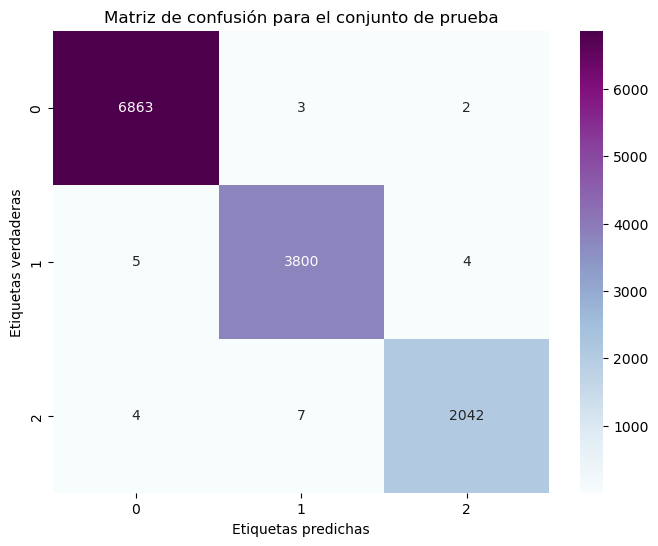

In [ ]:
param_gridDT = {
    'criterion': ['gini', 'entropy'],  # Función para medir la calidad de una división
    'max_depth': [None, 3, 5, 10, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 8],  # Muestras mínimas en una hoja
    'max_features': ['sqrt', 'log2', None]  # Número de características a considerar en cada división
}

decision_tree_model = DecisionTreeClassifier(random_state=random)

train_and_evaluate(decision_tree_model, param_gridDT, X_train, y_train, X_test, y_test)

*LDA*

Mejor modelo: {'shrinkage': 'auto', 'solver': 'lsqr'}
Test Metrics
     Métrica     Valor
0   Accuracy  0.815318
1  Precision  0.803564
2     Recall  0.815318
3   F1 Score  0.804778
Test Confusion Matrix
[[6491  213  164]
 [ 470 3013  326]
 [ 617  561  875]]


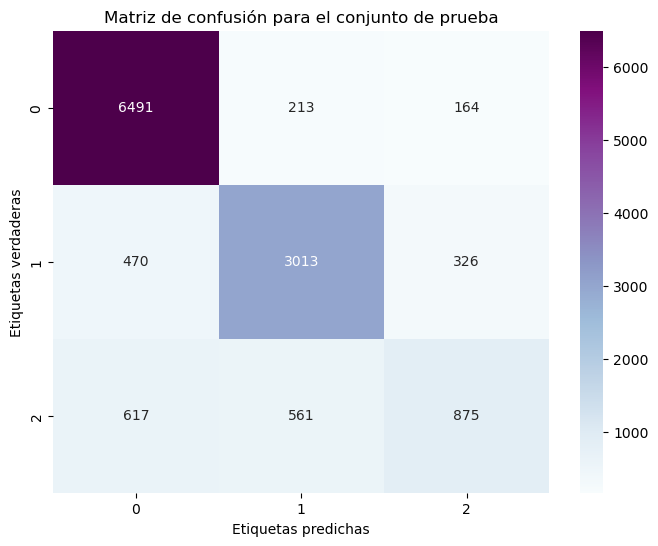

In [ ]:
param_gridLDA = {
    'solver': ['lsqr', 'eigen'],  # Excluye 'svd'
    'shrinkage': ['auto', 0.1, 0.5, 1.0]  # Compatible con 'lsqr' y 'eigen'
}

lda_model = LinearDiscriminantAnalysis()

train_and_evaluate(lda_model, param_gridLDA, X_train, y_train, X_test, y_test)